In [1]:
import numpy as np
import pulser
from pprint import pprint
from matplotlib import pyplot as plt

from scipy.linalg import expm

from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.waveforms import RampWaveform
from pulser.devices import Chadoq2

from IPython.display import HTML
import matplotlib.animation

/Users/Brian/workspace/Research/CO2_Capture_GNN/.conda/lib/python3.10/site-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [2]:
def Kron(*arr):
    K = arr[0]
    for i in range(1,len(arr)):
        K = np.kron(K,arr[i])
    return K

I = np.eye(2)
Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])

n = 4

Xi = np.concatenate(([Kron(X,*[I]*(n-1))],[Kron(*([I]*i+[X]+[I]*(n-i-1))) for i in range(1,n-1)],[Kron(*[I]*(n-1),X)]))
Zi = np.concatenate(([Kron(Z,*[I]*(n-1))],[Kron(*([I]*i+[Z]+[I]*(n-i-1))) for i in range(1,n-1)],[Kron(*[I]*(n-1),Z)]))
Ni = (np.eye(2**n)+Zi)/2



Omega = 1   * 2*np.pi
delta = 0.7 * 2*np.pi
U = 138e5

H = Omega/2*np.sum(Xi, axis=0) - delta*np.sum(Ni, axis=0)

v = Kron(*[np.array([0,1])]*n)

def Obs(v): # ,A
    # return (np.sum( [v.transpose().conj()@Ni[i]@v for i in A] )).real/len(A)
    return np.sum([ (v.transpose().conj()@Ni[i]@v).real for i in range(n)])



11.401181768748398


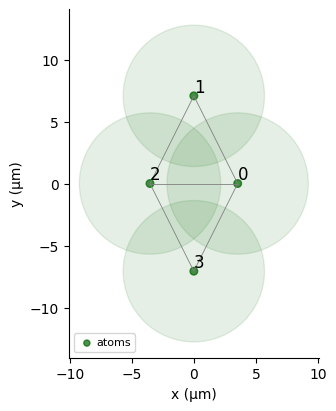

In [3]:
print((U/Omega)**(1/6))
w = np.exp(1j*2*np.pi/(n))

def graph(rNN):
    G1 = [[rNN/(2*np.sin(np.pi/(n)))*(w**i).real,rNN/(2*np.sin(np.pi/(n)))*(w**i).imag * 2] for i in range(n)]
    #G1 = [[rNN*i, 0] for i in range(n)]
    #G1 = [[rNN*(w**i).real,rNN*(w**i).imag] for i in range(n)]
    return G1

#rNN = 11
#G1 = [[rNN/(2*np.sin(np.pi/(n)))*(w**i).real,rNN/(2*np.sin(np.pi/(n)))*(w**i).imag] for i in range(n)]
G1 = graph(5)

Rij1 = np.zeros((n,n))
for i in range(n):
    for j in range(i):
        Rij1[i,j] = np.linalg.norm(np.array(G1[i])-np.array(G1[j]))
        Rij1[j,i] = Rij1[i,j]
        
#print(Rij1)
H1 = H.copy()
for i in range(n):
    for j in range(i):
        H1 += U/Rij1[i,j]**6 * (Ni[i]@Ni[j])# + Ni[j]@Ni[i])/2

qubits1 = dict(enumerate(G1))
reg1 = Register(qubits1)
reg1.draw(blockade_radius=(U/Omega)**(1/6), draw_half_radius=True, draw_graph=True)

In [4]:
M = 100
T = np.linspace(0.05,2.5,M)

O1_B = np.zeros((M))
O1_C = np.zeros((M))
O2_B = np.zeros((M))
O2_C = np.zeros((M))
for i,t in enumerate(T):
    vt = expm(-1j*t*H1)@v
    O1_B[i] = Obs(vt)#,B
    O1_C[i] = Obs(vt)#,C

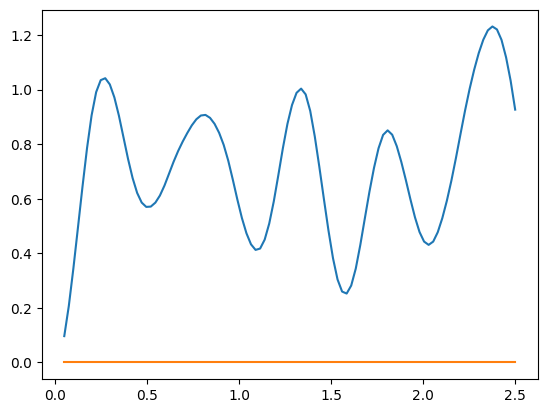

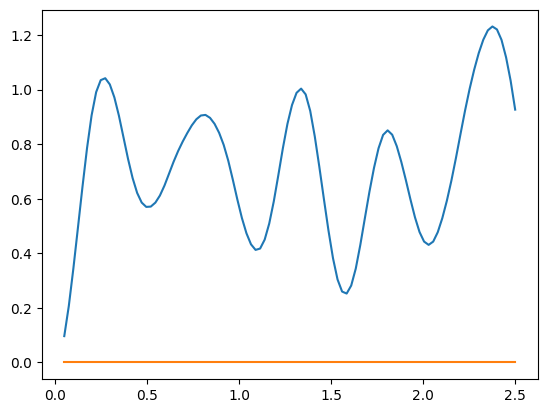

In [5]:

plt.plot(T,O1_B)
plt.plot(T,O2_B)
# plt.ylim([0,0.5])
plt.show()

plt.plot(T,O1_C)
plt.plot(T,O2_C)
plt.show()

In [6]:
K = 100
rNN_vec = np.linspace(25,0.5,K)
M = 200
T = np.linspace(0,15,M)

O = np.zeros((K,M))

w = np.exp(1j*2*np.pi/(n+1))


for k in range(K):
    if(k%10==0):
        print(k)
    #rNN = rNN_vec[k]
    #G1 = [[rNN/(2*np.sin(np.pi/(n)))*(w**i).real,rNN/(2*np.sin(np.pi/(n)))*(w**i).imag] for i in range(n)]
    G1 = graph(rNN_vec[k])

    Rij1 = np.zeros((n,n))
    for i in range(n):
        for j in range(i):
            Rij1[i,j] = np.linalg.norm(np.array(G1[i])-np.array(G1[j]))
            Rij1[j,i] = Rij1[i,j]

    H1 = H.copy()
    for i in range(n):
        for j in range(i):
            H1 += U/Rij1[i,j]**6 * (Ni[i]@Ni[j])
            
    for i,t in enumerate(T):
        vt = expm(-1j*t*H1)@v
        O[k,i] = Obs(vt)#,0)

0
10
20
30
40
50
60
70
80
90


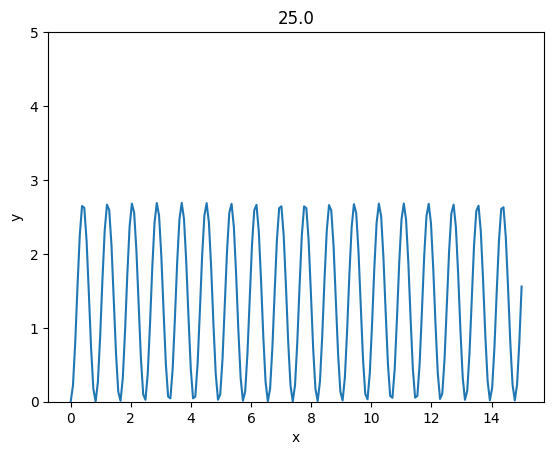

In [7]:
fig, ax = plt.subplots()
l, = plt.plot(T,O[0,:])
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_ylim([0,5])

def animate(i):
    l.set_data(T,O[i,:])
    ax.set_title(rNN_vec[i])
ani = matplotlib.animation.FuncAnimation(fig, animate, interval=25, frames=K)

       
HTML(ani.to_jshtml())

In [8]:
import scipy

In [9]:
FFT = np.zeros((K,M//2))
dt = T[1]-T[0]
xf = scipy.fft.fftfreq(M, dt)[:M//2]
for i in range(K):
    FFT[i,:] = 2/M*np.abs(scipy.fft.fft(O[i,:])[:M//2])
    # plt.plot(xf, 2.0/M * np.abs(yf[0:M//2]))

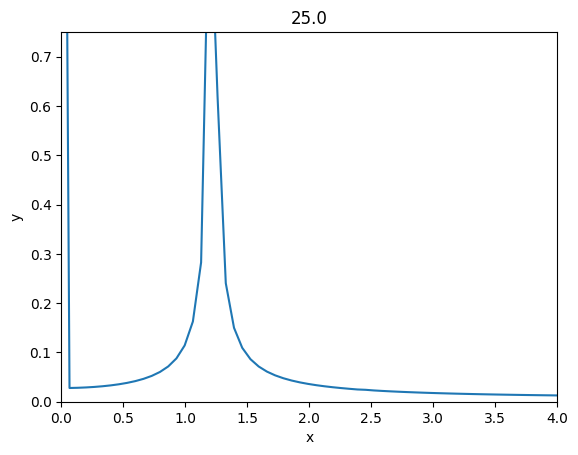

In [10]:
fig, ax = plt.subplots()
l, = plt.plot(xf,FFT[0,:])
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_ylim([0,0.75])
ax.set_xlim([0,4])

def animate(i):
    l.set_data(xf,FFT[i,:])
    ax.set_title(rNN_vec[i])
ani = matplotlib.animation.FuncAnimation(fig, animate, interval=100, frames=K)

       
HTML(ani.to_jshtml())

# ani.save('FFT_rNN_hexa.gif')

In [11]:
Omega/2/np.pi*np.sqrt(6)

2.449489742783178

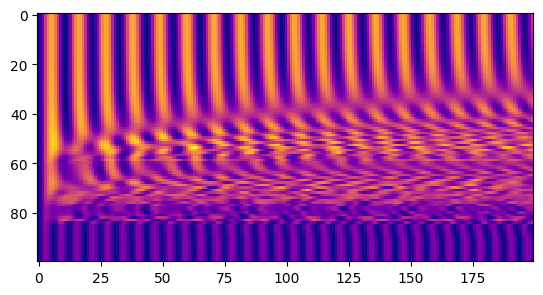

In [12]:

plt.imshow(O, cmap='plasma', interpolation='nearest')
plt.show()

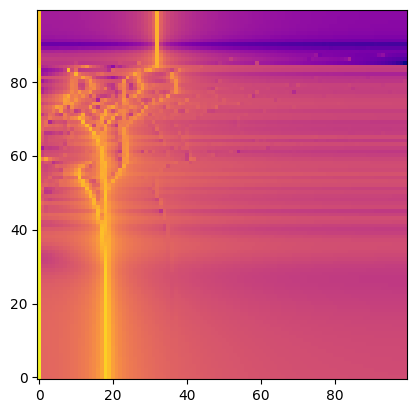

In [13]:
#fftbis = np.array([FFT[i,:],rNN_vec[i] for i in range(100)])
#print(fftbis.shape)

plt.imshow(np.log(FFT), cmap='plasma',origin='lower', interpolation='nearest')
plt.show()